In [3]:
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
args = OmegaConf.load('../colors.yml')

In [44]:
colors = {
    "MSP": "#3C6255",
    "entropy": "#61876E",
    "energy": "#A6BB8D",
    "|$\\Sigma$|": "#5078E3",
    "max($\\Sigma$)": "#3C43C7",
    "K-Means": "#D8D8D8"
}

edge_colors = {
    "NEG": args.red.dark,
    "POS": args.blue.dark,
    "border": "#3C6255"
}

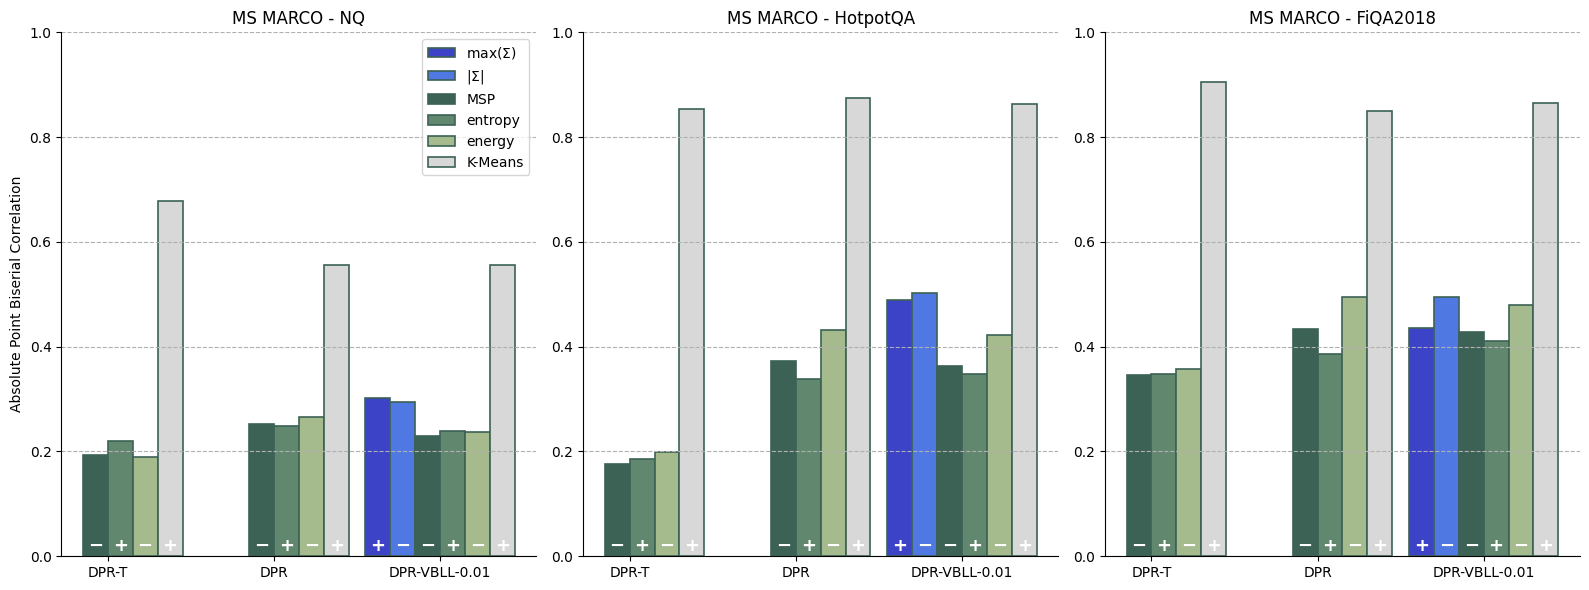

In [52]:
models = ['DPR-T', 'DPR', 'DPR-VBLL-0.01']
methods = ['max($\\Sigma$)', '|$\\Sigma$|', 'MSP', 'entropy', 'energy', 'K-Means']

scores = np.array([
    [np.nan, np.nan, -0.193, 0.220, -0.189, 0.679],   # DPR-T (only 3 methods)
    [np.nan, np.nan, -0.252, 0.248, -0.266, 0.555],   # DPR (only 3 methods)
    [0.303, -0.294, -0.229, 0.240, -0.238, 0.556],    # DPR-VBLL (4 methods)
])

n_models = len(models)
n_methods = len(methods)
bar_width = 0.15
x = np.arange(n_models)

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

for i, method in enumerate(methods):
    # Offset each method's bars
    offsets = (i - (n_methods-1)/2) * bar_width
    # Only plot bars where score is not nan
    valid = ~np.isnan(scores[:, i])
    bar_vals = scores[valid, i]   
    bars = axes[0].bar(x[valid] + offsets, abs(bar_vals), width=bar_width, label=method, color=colors[method], edgecolor=edge_colors['border'], linewidth=1.2)

    for bar, val in zip(bars, bar_vals):
        sign = "+" if val >= 0 else "−"
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            0.02,  # vertically centered on the bar
            sign,
            ha='center',
            va='center',
            color='white',
            fontsize=13,
            fontweight='bold'
        )

axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_ylim(0, 1)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel('Absolute Point Biserial Correlation')
axes[0].grid(True, axis='y', ls='--')
axes[0].set_title('MS MARCO - NQ')


scores = np.array([
    [np.nan, np.nan, -0.177, 0.186, -0.199, 0.854],# DPR-T (only 3 methods)
    [np.nan, np.nan, -0.372, 0.339, -0.432, 0.874],   # DPR (only 3 methods)
    [ 0.490, -0.502, -0.364, 0.347, -0.423, 0.863],    # DPR-VBLL (4 methods)
])

for i, method in enumerate(methods):
    # Offset each method's bars
    offsets = (i - (n_methods-1)/2) * bar_width
    # Only plot bars where score is not nan
    valid = ~np.isnan(scores[:, i])
    edges = [edge_colors['NEG'] if v < 0 else edge_colors['POS'] for v in scores[valid, i]]
    bar_vals = scores[valid, i]   
    bars = axes[1].bar(x[valid] + offsets, abs(bar_vals), width=bar_width, label=method, color=colors[method], edgecolor=edge_colors['border'], linewidth=1.2)

    for bar, val in zip(bars, bar_vals):
        sign = "+" if val >= 0 else "−"
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            0.02,  # vertically centered on the bar
            sign,
            ha='center',
            va='center',
            color='white',
            fontsize=13,
            fontweight='bold'
        )

axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_ylim(0, 1)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].grid(True, axis='y', ls='--')
axes[1].set_title('MS MARCO - HotpotQA')


scores = np.array([
    [np.nan, np.nan, -0.346, 0.348, -0.357, 0.906],# DPR-T (only 3 methods)
    [np.nan, np.nan,-0.434, 0.387, -0.495, 0.849],   # DPR (only 3 methods)
    [0.436, -0.495, -0.429, 0.410, -0.480, 0.865],    # DPR-VBLL (4 methods)
])

for i, method in enumerate(methods):
    # Offset each method's bars
    offsets = (i - (n_methods-1)/2) * bar_width
    # Only plot bars where score is not nan
    valid = ~np.isnan(scores[:, i])
    edges = [edge_colors['NEG'] if v < 0 else edge_colors['POS'] for v in scores[valid, i]]
    bar_vals = scores[valid, i]

    bars = axes[2].bar(x[valid] + offsets, abs(bar_vals), width=bar_width, label=method, color=colors[method], edgecolor=edge_colors['border'], linewidth=1.2)

    for bar, val in zip(bars, bar_vals):
        sign = "+" if val >= 0 else "−"
        axes[2].text(
            bar.get_x() + bar.get_width() / 2,
            0.02,  # vertically centered on the bar
            sign,
            ha='center',
            va='center',
            color='white',
            fontsize=13,
            fontweight='bold'
        )

axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].set_ylim(0, 1)
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].set_title('MS MARCO - FiQA2018')
axes[2].grid(True, axis='y', ls='--')
axes[0].legend()
plt.tight_layout()
plt.show()
fig.savefig(f"../figures/ood/ood-3.png", bbox_inches='tight', dpi=300)